In [1]:
#mount google drive when on google colab and set working directory

import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')


Working directory: /Users/kraehenb/music_speech


In [2]:
#check working directory and repo (git clone git@github.com:jkcas22/music_speech.git)

!{sys.executable} -m pip install gitpython
import git

repo = ['git@github.com:jkcas22/music_speech.git', 'https://github.com/jkcas22/music_speech.git']

if git.Repo(working_dir).remotes.origin.url in repo:
    print(f'\nRepository and working directory are fine.')
else:
    print(f'\nRepository: {git.Repo(working_dir).remotes.origin.url}')


Repository and working directory are fine.


In [3]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#import python code from seperate files
from helpers.fourier_transform import load_wav, dft_logmag, patches

2023-02-20 17:22:08.552576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]
music = list(set(music)-set(music_test))

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]
speech = list(set(speech)-set(speech_test))
	  
print (len(music), len(speech))

52 52


In [5]:
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

split = len(speech)*8//10

train = speech[:split] + music[:split]
train_labels = np.zeros(len(train))
train_labels[:split]=1

validate = speech[split:] + music[split:]
validate_labels = np.zeros(len(validate))
validate_labels[:len(speech[split:])]=1

In [6]:
test_sounds = load_wav(test)
train_sounds = load_wav(train)
validate_sounds = load_wav(validate)

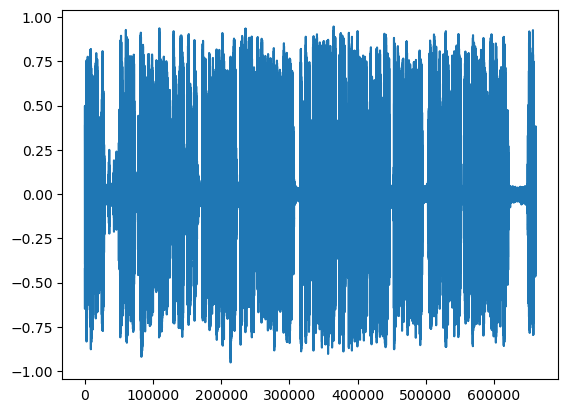

In [7]:
plt.plot(train_sounds[0])
plt.show()

In [8]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

test_logmag = dft_logmag(test_sounds,fft_chunks,fft_step,fft_size)
train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
validate_logmag = dft_logmag(validate_sounds,fft_chunks,fft_step,fft_size)

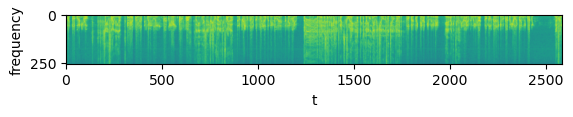

In [9]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [10]:
patch_step = 1
patch_size = 10

def ds_window(sound, label, patch_step, patch_size):
    labels = np.ones(len(sound))*label
    sound = np.c_[sound,labels]
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    return ds

def ds_patches(sounds, labels, patch_step, patch_size):
    ds = ds_window(sounds[0],labels[0],patch_step,patch_size)
    for sound, label in zip(sounds[1:],labels[1:]): ds = ds.concatenate(ds_window(sound,label,patch_step,patch_size))
    ds = ds.map(lambda x: (x[:,:-1], x[0,-1]))
    return ds

test_ds = ds_patches(test_logmag, test_labels, patch_step, patch_size)
train_ds = ds_patches(train_logmag, train_labels, patch_step, patch_size)
validate_ds = ds_patches(validate_logmag, validate_labels, patch_step, patch_size)

n_test = test_logmag.shape[0]*(((test_logmag.shape[1]-patch_size)//patch_step)+1)
n_train = train_logmag.shape[0]*(((train_logmag.shape[1]-patch_size)//patch_step)+1)
n_validate = validate_logmag.shape[0]*(((validate_logmag.shape[1]-patch_size)//patch_step)+1)

print(f"{n_test} samples for test.")
print(f"{n_train} samples for training.")
print(f"{n_validate} samples for validation.")

2023-02-20 17:22:51.929632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


61776 samples for test.
211068 samples for training.
56628 samples for validation.


In [11]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]}")

(10, 256) : [-6.61208383 -4.89688977] : [-4.6908063  -4.90940807]
(10, 256) : [-4.89688977 -4.98182374] : [-4.90940807 -4.44274937]
(10, 256) : [-4.98182374 -5.02795243] : [-4.44274937 -4.49532101]
(10, 256) : [-5.02795243 -8.36113194] : [-4.49532101 -5.72173546]
(10, 256) : [-8.36113194 -5.85684821] : [-5.72173546 -4.75245576]
(10, 256) : [-5.85684821 -5.16093334] : [-4.75245576 -4.37537448]
(10, 256) : [ -5.16093334 -10.41108328] : [-4.37537448 -4.16708189]
(10, 256) : [-10.41108328  -4.6908063 ] : [-4.16708189 -4.8389215 ]
(10, 256) : [-4.6908063  -4.90940807] : [-4.8389215  -5.12679297]
(10, 256) : [-4.90940807 -4.44274937] : [-5.12679297 -5.22613551]


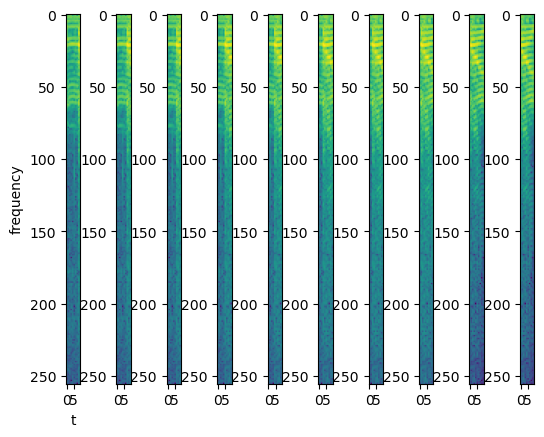

In [12]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy().T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

In [13]:
test_ds = test_ds.shuffle(n_test)
train_ds = train_ds.shuffle(n_train)
validate_ds = validate_ds.shuffle(n_validate)

test_x = test_ds.map(lambda x, y: x)
test_y = test_ds.map(lambda x, y: y)

train_x = train_ds.map(lambda x, y: x)
train_y = train_ds.map(lambda x, y: y)

validate_x = validate_ds.map(lambda x, y: x)
validate_y = validate_ds.map(lambda x, y: y)

print(f"Samples are shuffled now ... {[int(label.numpy()) for label in test_y.take(20)]} ...")

2023-02-20 17:23:09.139737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 46494 of 61776
2023-02-20 17:23:12.403626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


Samples are shuffled now ... [1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0] ...


In [14]:
train_logmag_patches = patches(train_logmag,patch_step,patch_size)
print(train_logmag_patches.shape)

(82, 2574, 10, 256)


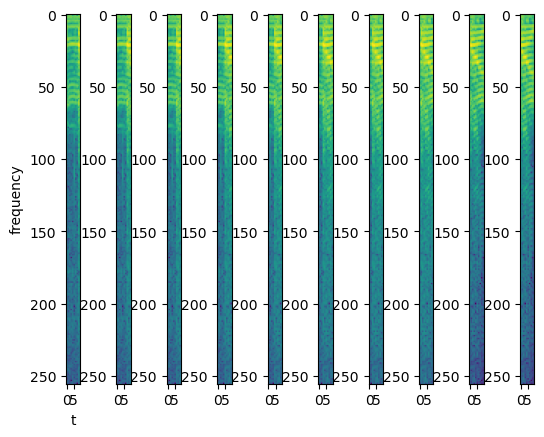

In [15]:
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(train_logmag_patches[0,i].T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()